In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

C:\Users\MaseLab Master\AppData\Local\Temp\ipykernel_20568\3442869956.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def initialize_membership_matrix(n, c):
    """
    初始化隸屬度矩陣
    n: 數據點數量
    c: 群聚數量
    """
    U = np.random.rand(n, c)
    U /= np.sum(U, axis=1, keepdims=True)
    return U

In [3]:
def update_centroids(data, U, m):
    """
    更新群聚中心點
    data: 數據點 (n_samples, n_features)
    U: 隸屬度矩陣 (n_samples, c)
    m: 模糊權重指數
    """
    um = U ** m
    return (data.T @ um / np.sum(um, axis=0)).T

In [4]:
def update_membership_matrix(data, centroids, m):
    """
    更新隸屬度矩陣
    data: 數據點 (n_samples, n_features)
    centroids: 群聚中心點 (c, n_features)
    m: 模糊權重指數
    """
    n = data.shape[0]
    c = centroids.shape[0]
    p = 2. / (m - 1)
    U = np.zeros((n, c))
    for i in range(n):
        x = data[i]
        dists = np.linalg.norm(x - centroids, axis=1)
        U[i] = 1. / np.sum((dists / dists[:, np.newaxis]) ** p, axis=0)
    return U

In [5]:
def fuzzy_c_means(data, c, m, error=0.005, maxiter=1000):
    """
    Fuzzy C-Means 算法實現
    data: 數據點 (n_samples, n_features)
    c: 群聚數量
    m: 模糊權重指數
    error: 收斂誤差閾值
    maxiter: 最大迭代次數
    """
    n = data.shape[0]
    U = initialize_membership_matrix(n, c)
    iteration = 0
    while iteration < maxiter:
        U_old = U.copy()
        centroids = update_centroids(data, U, m)
        U = update_membership_matrix(data, centroids, m)
        if np.linalg.norm(U - U_old) < error:
            break
        iteration += 1
    return U, centroids

In [8]:
# Load Indian Pines Hyperspectral Dataset

# 高光譜影像數據，三維資料集，分別是長、寬、光譜波段
img = np.load('indianpinearray.npy')
# 地面真實值(Ground Truth)，二維的對應每個數據點的歸屬
gt = np.load('IPgt.npy')
classes = np.unique(gt)

#將三維數據降至二維
data = img.reshape(-1, img.shape[-1])

U, centroids = fuzzy_c_means(data, c=16, m=1.5)
print("Centroids:", centroids)

Centroids: [[3036.02921377 4374.94165588 4640.08071391 ... 1060.95737139
  1030.63016911 1013.89543909]
 [2925.42693453 4186.53139356 4396.68269076 ... 1039.38572188
  1019.76966553 1010.33955117]
 [2914.84722825 3985.8700904  4139.72725787 ... 1017.23641805
  1009.02409004 1005.83798262]
 ...
 [3000.66014042 3891.96975608 4030.15398166 ... 1008.31293074
  1005.08979769 1004.26693973]
 [2919.7803975  4281.81168453 4516.36024417 ... 1055.80895104
  1028.0970258  1013.31948296]
 [2861.7894475  4194.58131083 4404.65794787 ... 1044.06788586
  1022.65594166 1011.66810517]]


In [14]:
labels = np.argmax(U, axis=1)
print(labels.shape)
clustered_img = labels.reshape(img.shape[:2])
print(clustered_img.shape)

# plt.figure(figsize=(10, 8))
# plt.imshow(clustered_img, cmap='viridis')
# plt.colorbar()
# plt.title('Fuzzy C-Means Clustering on HSI Data')
# plt.show()

(145, 145)

Accuracy: 23.82%


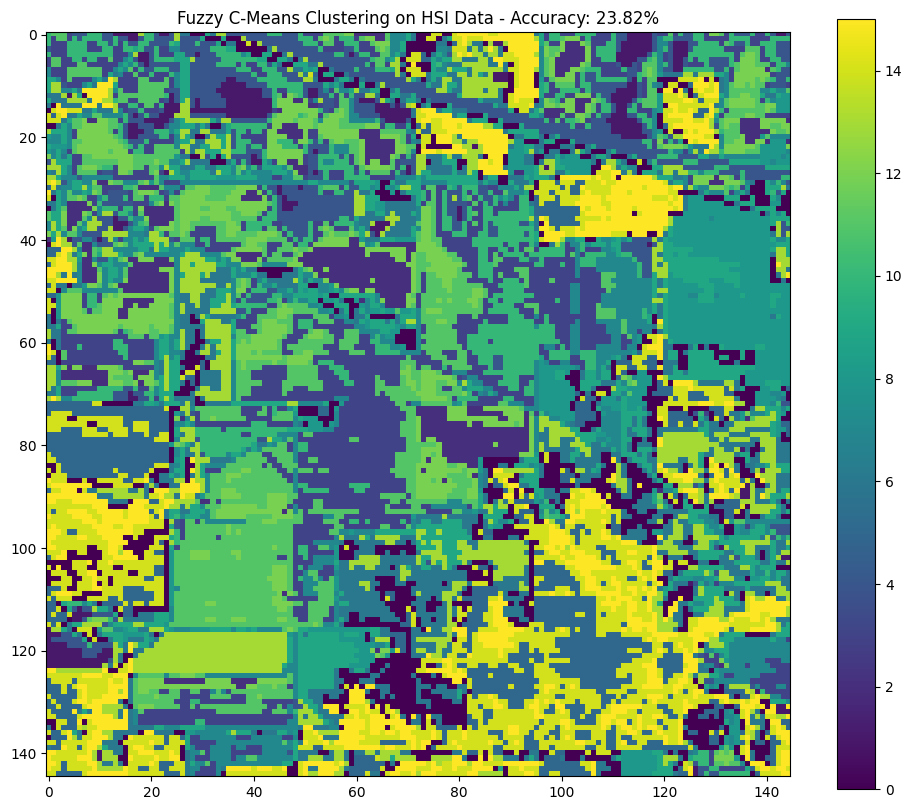

In [7]:
# 並且已經有 gt 加載和重塑為一維向量
gt_flat = gt.flatten()

# 計算混淆矩陣
cm = confusion_matrix(gt_flat, labels)

# 使用匈牙利算法找到最佳標籤對應
row_ind, col_ind = linear_sum_assignment(-cm)  # 對成本矩陣取負值以求最大化

# 建立標籤映射，根據找到的對應關系重映射 FCM 的結果
label_mapping = {col: row for col, row in zip(col_ind, row_ind)}
remapped_labels = np.array([label_mapping[label] for label in labels])

# 計算重映射後的準確率
accuracy = np.sum(remapped_labels == gt_flat) / gt_flat.size
print(f"Accuracy: {accuracy * 100:.2f}%")

# 可視化重映射後的分群結果
remapped_clustered_img = remapped_labels.reshape(img.shape[:2])

plt.figure(figsize=(12, 10))
plt.imshow(remapped_clustered_img, cmap='viridis')
plt.colorbar()
plt.title(f'Fuzzy C-Means Clustering on HSI Data - Accuracy: {accuracy * 100:.2f}%')
plt.show()